In [14]:
import numpy as np
import networkx as nx
from scipy import linalg as LA
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [257]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, n_dontknow = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    verts = np.array(verts)
    faces = np.array(faces)
    return verts, faces

In [79]:
def write_off(filename, vertex, face):
    with open(filename, 'a') as f:
        f.write('OFF\n');
        f.write('%d %d 0\n'%(vertex.shape[0], face.shape[0]))
        np.savetxt(f, vertex, fmt='%f %f %f')
        np.savetxt(f, face, fmt='3 %d %d %d')

In [14]:
with open('./data/simp.off','r') as f:
    verts, faces = read_off(f)

In [270]:
def deg_cal(in_faces):
    out_faces = np.concatenate([in_faces[:,:2], in_faces[:,1:3], in_faces[:,[0,2]]], axis=0)
    out_faces = np.concatenate([out_faces,out_faces[:,::-1]], axis=0)
    out_faces = np.unique(out_faces, axis=0)
    _, deg = np.unique(out_faces[:,0], return_counts=True)
    return out_faces, deg

In [13]:
def simplifiedMapping(simp_vertex, org_vertex):
    """
    This function is able to map the simplified vertex
    to the orginal vertex by using k-d tree
    """
    kd_tree = KDTree(simp_vertex)
    _, idx = kd_tree.query(org_vertex, k = 1)
    return idx

In [17]:
graph_edg_idx, deg = deg_cal(faces)
deg_mat = np.diag(deg)

In [20]:
G = nx.Graph()

G.add_edges_from(graph_edg_idx)
adj = nx.adjacency_matrix(G, nodelist=range(G.number_of_nodes())).todense().astype(float)

In [29]:
rt = adj.copy()

In [30]:
adj_idx = np.argwhere(rt==1)

In [31]:
for idx in adj_idx:
    i, j = idx
    normy = (verts[i,:] - verts[j,:]) ** 2
    factor = np.sum(normy)
    rt[i, j] = 1 / factor

In [36]:
Lap_mat = np.diagflat(np.sum(rt ,axis=1)) - rt

In [39]:
eign_val, eigen_vec = LA.eigh(Lap_mat)

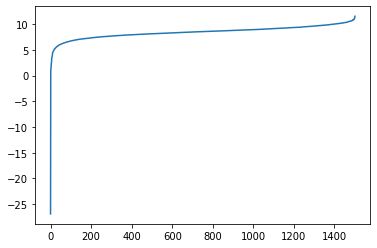

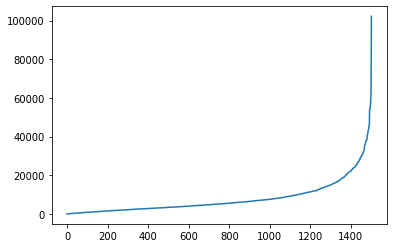

In [40]:
plt.plot(eign_val)
plt.plot(np.log(np.abs(eign_val)))
plt.figure()

In [41]:
Log_eigen = np.log(np.abs(eign_val))

In [42]:
N = 9
def append_eigen(eigen, N):
    if (N % 2) == 1:
        out_eign = np.concatenate([np.repeat(eigen[0], N/2), eigen, np.repeat(eigen[-1], N/2)])
    else:
        raise("Please input an odd number")
    return out_eign

In [43]:
spec_irregu = np.abs(Log_eigen - np.convolve(append_eigen(Log_eigen,N), np.ones((N,))/N, mode='valid'))

In [44]:
spec_irregu

array([1.26817814e+01, 1.18919798e+01, 8.90954199e+00, ...,
       1.58419869e-01, 1.18670032e-02, 2.10781120e-01])

In [58]:
Saliency_mat = np.multiply(np.dot(np.dot(eigen_vec, np.diagflat(np.exp(spec_irregu))), eigen_vec.T), rt)

In [60]:
Saliency_vec = Saliency_mat.sum(axis=1).reshape(-1)

In [61]:
Saliency_vec

matrix([[1982393.59962323, 2348299.1754106 , 1306937.1957651 , ...,
         1842598.39555642,  587472.77105265,  568428.54934543]])

## Section 3 part code

In [110]:
def find_boundBoxDiag(vertx):
    """
    This function will find the boundbox based on the vertx
    """
    max_vec = np.max(vertx, axis=0)
    min_vec = np.min(vertx, axis=0)
    diff_vec = (max_vec - min_vec) ** 2
    return np.sqrt(np.sum(diff_vec))

In [117]:
def gaussian_kernel(x, t):
    return (1/np.sqrt(2*np.pi*t)) * np.exp(-np.dot(x.T, x) / 2*(t))

In [191]:
def aver_inter_distance(vertex):
    summ = 0
    for i in range(vertex.shape[0]):
        for j in range(vertex.shape[0]):
            summ += np.sum((vertex[i,:] - vertex[j:])**2)
    summ = summ * 2 / (vertex.shape[0]*(vertex.shape[0]-1))
    return summ

In [212]:
c = np.sqrt(aver_inter_distance(verts))

In [204]:
lenDiag_Bound = find_boundBoxDiag(verts)
eps = (2e-3**2) * lenDiag_Bound

In [205]:
t = [k*eps for k in range(1,6)]

In [206]:
z = np.zeros(verts.shape).astype(np.float)
for i in range(verts.shape[0]):
    z[i,:] = verts[i,:] * gaussian_kernel(verts[i,:], t[0])

In [207]:
! rm -f ./tst_gaus.off
write_off('./tst_gaus.off', z, faces)

In [208]:
kk_vec = np.zeros(verts.shape[0]).astype(np.float)
for i in range(verts.shape[0]):
    adj_set = np.argwhere(np.array(adj[i,:]).reshape(-1) == 1)
    summm = np.sum(np.sqrt(np.sum(((verts[i] - verts[adj_set,:])**2).reshape(-1,3), axis=1)))
    kk_vec[i] = (c*deg[i])/summm + 1

In [209]:
k_tParam = kk_vec * t[0]

In [210]:
z2 = np.zeros(verts.shape).astype(np.float)
for i in range(verts.shape[0]):
    z2[i,:] = verts[i,:] * gaussian_kernel(verts[i,:], k_tParam[i])

In [211]:
! rm -f ./tst_gaus2.off
write_off('./tst_gaus2.off', z2, faces)

In [335]:
def gaussian_smoothing_dynamic(vertex_info, adj_mat, alpha=1):
    new_ver = np.zeros(vertex_info.shape).astype(np.float)
    for i in range(vertex_info.shape[0]):
        adj_set = np.argwhere(np.array(adj_mat[i,:]).reshape(-1) == 1)
        adj_coord = vertex_info[adj_set,:].reshape(-1,3)
        ver_i_coord = vertex_info[i,:].reshape(-1,3)
        weight_set = np.zeros(adj_set.shape[0]).astype(np.float) 
        sigma = np.sum(np.sqrt(np.sum((ver_i_coord - adj_coord)**2, axis = 1)))/adj_set.shape[0] * alpha
        for j in range(adj_set.shape[0]):
            d_temp = np.sum((ver_i_coord - adj_coord[j,:])**2)
            weight_set[j] = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-d_temp / (2*(sigma**2)))
        weight_set = weight_set / np.sum(weight_set)
        new_ver[i,:] = np.dot(weight_set.T, adj_coord)
    return new_ver

In [336]:
def gaussian_smoothing(vertex_info, adj_mat, alpha=1):
    new_ver = np.zeros(vertex_info.shape).astype(np.float)
    for i in range(vertex_info.shape[0]):
        adj_set = np.argwhere(np.array(adj_mat[i,:]).reshape(-1) == 1)
        adj_coord = vertex_info[adj_set,:].reshape(-1,3)
        ver_i_coord = vertex_info[i,:].reshape(-1,3)
        weight_set = np.zeros(adj_set.shape[0]).astype(np.float) 
        sigma = alpha
        for j in range(adj_set.shape[0]):
            d_temp = np.sum((ver_i_coord - adj_coord[j,:])**2)
            weight_set[j] = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-d_temp / (2*(sigma**2)))
        weight_set = weight_set / np.sum(weight_set)
        new_ver[i,:] = np.dot(weight_set.T, adj_coord)
    return new_ver

In [281]:
with open('./data/0.off','r') as f:
    verts2, faces2 = read_off(f)

In [282]:
a, b = deg_cal(faces2)
G2 = nx.Graph()
G2.add_edges_from(a)
adj2 = nx.adjacency_matrix(G2, nodelist=range(G2.number_of_nodes())).todense().astype(float)

In [333]:
new_ver = gaussian_smoothing_dynamic(verts, adj)

In [334]:
! rm -f ./tst_gaus2.off
write_off('./tst_gaus2.off', new_ver, faces)

In [340]:
! rm -f ./tst_gaus3.off
write_off('./tst_gaus3.off', new_ver, faces)

In [330]:
new_ver

array([[ 0.33686052,  0.36625566, -0.02505359],
       [-0.2164311 , -0.87552183,  0.05208472],
       [ 0.26964398,  0.39290159, -0.02622854],
       ...,
       [ 0.10950396,  0.62890961,  0.01107857],
       [ 0.04183545,  0.14133887, -0.06423714],
       [-0.01662701,  0.42546679, -0.10579393]])

In [320]:
new_ver

array([[ 0.33953433,  0.36127089, -0.02488993],
       [-0.21612372, -0.8750902 ,  0.05354227],
       [ 0.27487488,  0.38869757, -0.02633849],
       ...,
       [ 0.10794163,  0.62876391,  0.01061858],
       [ 0.04671724,  0.14153588, -0.06381883],
       [-0.01533605,  0.42062899, -0.10530095]])

In [321]:
verts

array([[ 0.33822 ,  0.368726, -0.026221],
       [-0.224259, -0.877597,  0.052352],
       [ 0.280568,  0.385197, -0.033369],
       ...,
       [ 0.116834,  0.627539,  0.011516],
       [ 0.060451,  0.134235, -0.059194],
       [-0.007087,  0.40326 , -0.101193]])

In [337]:
new_ver_nonDynamic = gaussian_smoothing(verts, adj)

In [338]:
new_ver_nonDynamic

array([[ 0.3354906 ,  0.36887024, -0.02501799],
       [-0.21664297, -0.87567981,  0.05142495],
       [ 0.26725075,  0.3948976 , -0.02618578],
       ...,
       [ 0.1100835 ,  0.62890755,  0.01118543],
       [ 0.040122  ,  0.14114567, -0.06437524],
       [-0.01702728,  0.42708052, -0.10595591]])

In [341]:
! rm -f ./tst_gaus4.off
write_off('./tst_gaus4.off', new_ver_nonDynamic, faces)

In [5]:
rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))
kd_tree = KDTree(X)

In [12]:
dist, ind = kd_tree.query(np.array([[0, 1, 2], [23, 2, 1]]).reshape(-1,3), k=1)
dist, ind

(array([[ 1.13012854],
        [22.11255712]]), array([[2],
        [9]]))